# Reinterpreting Virginia Woolf Through Sentiment Analysis
KAELA OLSEN, Cornell University, English & Information Science<br>
<br> 
December 20, 2020<br>
ENGL 3520: Virginia Woolf<br> 
Professor Elizabeth Evans<br>

## Introduction

**Virginia Woolf:**<br>
Virginia Woolf is one of English Literature's most famed novelists, a canonical figure of Ango-American modernism. Considered one of the most important 20th-century writers, Woolf pioneered, among other things, her own style of free indirect discourse and stream-of-conscious narratives. Many of her works, including the notable Mrs. Dalloway and To The Lighthouse, are considered iconic modernist texts that truly defined the genre and the era.<br>

Novels like these placed Woolf at the center of the modernist reinvention of literature, specifically novels, to focus on the subjective, rather than objective, human experience. However, critical essays like A Room of One's Own and Three Guineas positioned her as a respected and perceptive social critic who wrote in support of feminism and anti-colonial pacifism. While Woolf's works span various genres, covering biographies and political critiques, her writing style is unique in her lyrical novels. Her novels and short stories often take topics previously considered mundane and commonplace and create intricate and engaging discourse within each character. The intensity of Woolf's writing style and her ability to evoke emotion out of almost every and any situation create worlds abundant with emotion.

**This Project:**<br>
Through text-mining and data analysis, this project hopes to paint an alternate picture of the emotions that illuminate and illustrate the worlds Woolf creates, to quantitatively visualize the fluctuation of emotions within her characters, her worlds, and her ideas. We will rediscover Woolf’s most influential novels, essays, and stories through the quantitative analysis of sentiment throughout her texts. By restructuring the character, arguments, opinions, and consciousnesses that Woolf created, we can reinterpret the emotion weaved throughout her texts and, through new lenses, revisit the worlds that Woolf created.

**Research Questions:**<br>
This research study analyzes the sentences which construct Woolf's novels to investigate further the role of positive and negative emotion in her work. By interpreting the mood of her texts' sentences and words, we might visualize how emotion changes throughout each text. How do our quantitative analysis of sentiment compare and contrast to our qualitative analysis? What differences in understanding arise when replacing a human interpreter, reading sentence by sentence, with a computer interpreter that parses through sentence by sentence? How might these differences cause us to think more critically about Woolf's texts?

**Method Overview:**<br>
Sentiment analysis is a text analysis method that detects polarity within a text, whether a whole document, paragraph, sentence, or clause. With sentiment analysis using the VADER method (discussed below), we hope to measure the speaker's attitude, sentiments, and emotions based on the computational treatment of subjectivity in each of Woolf's texts.

**Data Description**<br>
The data used for this sentiment analysis was web-scraped from online e-books provided by Project Gutenberg Australia, which provides free e-books by authors who died before 1955. Using BeautifulSoup to process each web page, I extracted the text from each site, often correlated with Woolf's respective work. After extracting the text, I processed it into sentences through a text-mining function written below. Upon separating the text into sentences (which proved more complicated than anticipated!), I created a dataframe for each text, each row an individual sentence. Then, with a dataframe made for each of Woolf's text, I was ready to perform some exciting analyses!

## Data Collection: Web-Scraping

In [1]:
import re
import requests
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.transforms as transforms

Below, I create a function that extracts the relevant text from the webpage URLs. This function uses requests to pull the URL's content, then BeautifulSoup parses through the HTML to access the page's text. It removes any text in extraneous headings, footers, tables, etc., and returns one massive string of text.

In [2]:
def text_from_url(url):
    '''Pull a textfield from a HTML website from each <p> div class.
    Returns a textfield.'''
    
    res = requests.get(url)
    html_page = res.content
    soup = BeautifulSoup(html_page, 'html.parser')
    text = soup.find_all(text=True)
    
    output = ''
    blacklist = ['[document]','a','b','big','blockquote','body','center','font','i','h1','h2','head','html','pre','style','table','td','title','tr']

    for t in text:
        if t.parent.name not in blacklist:
            output += '{} '.format(t)
    return output

As an example, we can see what the function text_from_url might output after pulling the text off of the Gutenberg webpage for <em>Mrs. Dalloway</em>, one of Woolf's most notable novels:

In [3]:
mrs_dalloway_url = 'http://gutenberg.net.au/ebooks02/0200991h.html'
mrs_dalloway = text_from_url(mrs_dalloway_url)
mrs_dalloway 

'\xa0 \xa0 \xa0 \xa0 \xa0 \xa0 \xa0 \xa0 Mrs. Dalloway said she would buy the flowers herself. For Lucy had her work cut out for her. The doors would be taken\r\noff their hinges; Rumpelmayer\'s men were coming. And then, thought\r\nClarissa Dalloway, what a morning--fresh as if issued to children on\r\na beach. What a lark! What a plunge! For so it had always seemed to her,\r\nwhen, with a little squeak of the hinges, which she could hear now,\r\nshe had burst open the French windows and plunged at Bourton into the\r\nopen air. How fresh, how calm, stiller than this of course, the air\r\nwas in the early morning; like the flap of a wave; the kiss of a\r\nwave; chill and sharp and yet (for a girl of eighteen as she then\r\nwas) solemn, feeling as she did, standing there at the open window,\r\nthat something awful was about to happen; looking at the flowers, at\r\nthe trees with the smoke winding off them and the rooks rising,\r\nfalling; standing and looking until Peter Walsh said, "Mu

While we were able to successfully pull out all of the text we are interested in, we caught a decent amount of gibberish as well! The \r\n's represent line breaks in the text on the webpage. Now, we have to create a function that will allow us to parse through this complicated jumble of characters and pull out a clean list of sentences instead.

In [4]:
alphabets = "([A-Za-z])"
prefixes = "(Mr|St|Mrs|Ms|Dr|Prof|Capt|Cpt|Lt|Mt)[.]"
suffixes = "(Inc|Ltd|Jr|Sr|Co)"
starters = "(Mr|Mrs|Ms|Dr|He\s|She\s|It\s|They\s|Their\s|Our\s|We\s|But\s|However\s|That\s|This\s|Wherever)"
acronyms = "([A-Z][.][A-Z][.](?:[A-Z][.])?)"

def extract_sentences(text):
    '''Manipulate a textfield into a list of strings, where each string is a new sentence.
    Returns a string of individual sentences within a textfield.'''
   
    text = " " + text + "  "
    text = text.replace("\n"," ")
    text = text.replace("\r","")
    text = re.sub(prefixes,"\\1<prd>",text)
    
    if "Ph.D" in text: text = text.replace("Ph.D.","Ph<prd>D<prd>")
    if "..." in text: text = text.replace("...","<prd><prd><prd>")

    text = re.sub("\s" + alphabets + "[.] "," \\1<prd> ",text)
    text = re.sub(acronyms+" "+starters,"\\1<stop> \\2",text)
    text = re.sub(alphabets + "[.]" + alphabets + "[.]" + alphabets + "[.]","\\1<prd>\\2<prd>\\3<prd>",text)
    text = re.sub(alphabets + "[.]" + alphabets + "[.]","\\1<prd>\\2<prd>",text)
    text = re.sub(" "+suffixes+"[.] "+starters," \\1<stop> \\2",text)
    text = re.sub(" "+suffixes+"[.]"," \\1<prd>",text)
    text = re.sub(" " + alphabets + "[.]"," \\1<prd>",text)
    
    if "”" in text: text = text.replace(".”","”.")
    if "\"" in text: text = text.replace(".\"","\".")
    if "!" in text: text = text.replace("!\"","\"!")
    if "?" in text: text = text.replace("?\"","\"?")

    text = text.replace("\ ", "")
    text = text.replace(".",".<stop>")
    text = text.replace("?","?<stop>")
    text = text.replace("!","!<stop>")
    text = text.replace("<prd>",".")

    sentences = text.split("<stop>")
    sentences = sentences[:-1]
    sentences = [s.strip() for s in sentences]

    return sentences

The function above takes the vast clump of text from above, sorts through character by character, replaces, and removes any letters or symbols we do not want. There are quite a few hoops this function jumps over; it must successfully discern sentence breaks from words like "Dr.," "Inc.," and even understand what to do with quotations that indicate new speakers.

We can see how successful our function is at pulling apart the different sentences by employing the same example.

In [5]:
mrs_dalloway_sentence_list = extract_sentences(mrs_dalloway)
mrs_dalloway_sentence_list

['Mrs. Dalloway said she would buy the flowers herself.',
 'For Lucy had her work cut out for her.',
 "The doors would be taken off their hinges; Rumpelmayer's men were coming.",
 'And then, thought Clarissa Dalloway, what a morning--fresh as if issued to children on a beach.',
 'What a lark!',
 'What a plunge!',
 'For so it had always seemed to her, when, with a little squeak of the hinges, which she could hear now, she had burst open the French windows and plunged at Bourton into the open air.',
 'How fresh, how calm, stiller than this of course, the air was in the early morning; like the flap of a wave; the kiss of a wave; chill and sharp and yet (for a girl of eighteen as she then was) solemn, feeling as she did, standing there at the open window, that something awful was about to happen; looking at the flowers, at the trees with the smoke winding off them and the rooks rising, falling; standing and looking until Peter Walsh said, "Musing among the vegetables"?',
 '--was that it?',

Success! From glancing at the initial textfield output above, the function appears to have provided a nice, clean list of each sentence in Mrs. Dalloway. However, there is not much opportunity for data analysis with just this textfield; it would be much easier to work with a dataframe. Thus, we can turn this list into a handy dataframe via a package called pandas.

In [6]:
mrs_dalloway_sentence_df = pd.DataFrame(mrs_dalloway_sentence_list).rename(columns={0: 'sentence'})
mrs_dalloway_sentence_df

,sentence
0,Mrs. Dalloway said she would buy the flowers h...
1,For Lucy had her work cut out for her.
2,The doors would be taken off their hinges; Rum...
3,"And then, thought Clarissa Dalloway, what a mo..."
4,What a lark!
...,...
3709,what is this ecstasy?
3710,he thought to himself.
3711,What is it that fills me with extraordinary ex...
3712,"It is Clarissa, he said."


From slotting all the sentences into a dataframe, we can get a better handle on the data. Previewing the dataframe shows us the first five and last five sentences of each book, which all checks out. As shown by the 3714 rows, there are 3714 sentences in Mrs. Dalloway. The last sentence, "For there she was," reads even more powerfully when alone in its own dataframe cell!

Now, we have a sturdy process in place for extracting each publication's text off of the Gutenberg website, processing the extraction, and polishing it off into sentences. However, it is a tedious process, especially if we hope to redo it multiple times for a dozen or so Woolf works. Let us streamline this entire process into one function that starts with the webpage URL and returns the ready-to-use dataframe.

In [7]:
def url_to_df(url):
    '''Extract each sentence of a given text from the HTML url provided.
    Returns dataframe where each row is an individual sentence.'''
    text = text_from_url(url)
    sentences = extract_sentences(text)
    df = pd.DataFrame(sentences).rename(columns={0: 'sentence'})
    return df

Only about half of Woolf's texts, provided by Project Gutenberg, are on HTML pages. The rest are on TXT pages (as indicated by the '.txt' at the end of the URL). For .txt webpages, using requests to pull the page's contents gives us the entire chunk of text directly. Thus, we can store the text and run the same extract_sentences function to parse through the text for each sentence and then pull it all together into a dataframe as we did before. The function below does precisely this.

In [8]:
def txt_to_df(txt):
    '''Extract each sentence of a given text from the TXT url provided.
    Returns dataframe where each row is an individual sentence.'''
    response = requests.get(txt)
    data = response.text
    sentences = extract_sentences(data)
    df = pd.DataFrame(sentences).rename(columns={0: 'sentence'})
    return df

With these two functions, we can populate new dataframes for the rest of Woolf's works that we would like to analyze. This research will look at the following texts by Woolf:

<em>Novels:</em>
- The Voyage Out, 1915
- Night and Day, 1919
- Jacob's Room, 1922
- Mrs. Dalloway, 1925
- To the Lighthouse, 1927
- The Waves, 1931
- The Years, 1937
- Between the Acts, 1941

<em>Short Stories:</em>
- The Mark On the Wall, 1917
- Kew Gardens, 1919
- Street Haunting, 1930

<em>Biographies:</em>
- Orlando: A Biography, 1928
- Flush: A Biography, 1933

<em>Essays:</em>
- Modern Fiction, 1921
- Mr. Bennett and Mrs. Brown, 1923
- A Room of One's Own, 1929
- Three Guineas, 1938

Onto the data processing!

## Data Processing: Text-Mining

As seen below, each publication has its own webpage (aside from the short stories, which sometimes share a page). The functions we created above, url_to_df and txt_to_df, successfully create sentence dataframes for us. 

Unfortunately, a few websites had tricky formatting for the texts' headings and subheadings, especially with the .txt webpages. This produced some dataframes where the first few rows of sentences were things like 'VIRGINIA WOOLF PUBLISHED BY LEONARD AND VIRGINIA WOOLF  AT THE HOGARTH PRESS TAVISTOCK SQUARE  LONDON W.C.I 1924 MR.'. Thus, I had to remove these wonky rows through '.iloc[]' and then reset the index for the dataframe. Through a little manipulation, we escape with some clean datasets!

In [9]:
# The Voyage Out (1915)
voyage_out_url = 'http://gutenberg.net.au/ebooks/m00020.txt'
voyage_out = txt_to_df(voyage_out_url)
voyage_out['sentence'][0] = voyage_out['sentence'][0].replace('Project Gutenberg Australia    THE VOYAGE OUT (1915) by Virginia Woolf (1882-1941)    Chapter I   ', '', 1)
voyage_out

,sentence
0,As the streets that lead from the Strand to th...
1,"If you persist, lawyers' clerks will have to m..."
2,In the streets of London where beauty goes unr...
3,One afternoon in the beginning of October when...
4,Angry glances struck upon their backs.
...,...
8399,Pepper beaten at last?
8400,"I congratulate you""!"
8401,"said Arthur Venning, who was wheeling old Mrs...."
8402,All these voices sounded gratefully in St. Joh...


In [10]:
# Mr. Bennett and Mrs. Brown (1923)
bennett_brown_url = 'http://www.gutenberg.org/files/63022/63022-h/63022-h.htm'
bennett_brown = url_to_df(bennett_brown_url).iloc[2:].reset_index(drop=True)
bennett_brown['sentence'][0] = bennett_brown['sentence'][0].replace('BROWN ', '', 1)
bennett_brown

,sentence
0,"It seems to me possible, perhaps desirable, th..."
1,"And when I asked myself, as your invitation to..."
2,"Catch me if you can""."
3,Most novelists have the same experience.
4,"Some Brown, Smith, or Jones comes before them ..."
...,...
376,"Tolerate the spasmodic, the obscure, the fragm..."
377,Your help is invoked in a good cause.
378,For I will make one final and surpassingly ras...
379,But it can only be reached if we are determine...


In [11]:
# Flush: A Biography (1933)
flush_url = 'http://gutenberg.net.au/ebooks03/0301041h.html'
flush = url_to_df(flush_url)
flush

,sentence
0,It is universally admitted that the family fro...
1,Therefore it is not strange that the origin of...
2,Many million years ago the country which is no...
3,Ages passed; vegetation appeared; where there ...
4,There is nothing in this that calls for questi...
...,...
2148,"[10] ""he was now dead""."
2149,It is certain that Flush died; but the date an...
2150,The only reference consists in the statement t...
2151,Mrs. Browning was buried in the English Cemete...


In [12]:
# Mrs. Dalloway (1925)
mrs_dalloway_url = 'http://gutenberg.net.au/ebooks02/0200991h.html'
mrs_dalloway = url_to_df(mrs_dalloway_url)
mrs_dalloway 

,sentence
0,Mrs. Dalloway said she would buy the flowers h...
1,For Lucy had her work cut out for her.
2,The doors would be taken off their hinges; Rum...
3,"And then, thought Clarissa Dalloway, what a mo..."
4,What a lark!
...,...
3709,what is this ecstasy?
3710,he thought to himself.
3711,What is it that fills me with extraordinary ex...
3712,"It is Clarissa, he said."


In [13]:
# To the Lighthouse (1927)
to_the_lighthouse_url = 'http://gutenberg.net.au/ebooks01/0100101h.html'
to_the_lighthouse = url_to_df(to_the_lighthouse_url)
to_the_lighthouse['sentence'][0] = to_the_lighthouse['sentence'][0].replace('by', '', 1)
to_the_lighthouse

,sentence
0,"""Yes, of course, if it's fine tomorrow,"" said..."
1,"""But you'll have to be up with the lark,"" she ..."
2,To her son these words conveyed an extraordina...
3,"Since he belonged, even at the age of six, to ..."
4,It was fringed with joy.
...,...
3510,"she asked herself, taking up her brush again."
3511,She looked at the steps; they were empty; she ...
3512,"With a sudden intensity, as if she saw it clea..."
3513,It was done; it was finished.


In [14]:
# Orlando: A Biography (1928)
orlando_url = 'http://gutenberg.net.au/ebooks02/0200331h.html'
orlando = url_to_df(orlando_url).iloc[18:].reset_index(drop=True)
orlando

,sentence
0,"He--for there could be no doubt of his sex, th..."
1,"It was the colour of an old football, and more..."
2,"Orlando's father, or perhaps his grandfather, ..."
3,Orlando's fathers had ridden in fields of asph...
4,"So too would Orlando, he vowed."
...,...
3407,Her pearls burnt like a phosphorescent flare i...
3408,"And as Shelmerdine, now grown a fine sea capta..."
3409,'It is the goose!
3410,' Orlando cried.


In [15]:
# Three Guineas (1938)
three_guineas_url = 'http://gutenberg.net.au/ebooks02/0200931h.html'
three_guineas = url_to_df(three_guineas_url)
three_guineas

,sentence
0,Three years is a long time to leave a letter u...
1,"I had hoped that it would answer itself, or th..."
2,But there it is with its question--How in your...
3,--still unanswered.
4,It is true that many answers have suggested th...
...,...
3483,.
3484,Cette individualité n'a par elle seule ni sign...
3485,Elle ne prend un sens quelconque qu'en devenan...
3486,"' ( by George Sand, pp."


In [16]:
# Between the Acts (1941)
between_the_acts_url = 'http://gutenberg.net.au/ebooks03/0301171h.html'
between_the_acts = url_to_df(between_the_acts_url)
between_the_acts

,sentence
0,"It was a summer's night and they were talking,..."
1,The county council had promised to bring water...
2,"Mrs. Haines, the wife of the gentleman farmer,..."
3,Then there was silence; and a cow coughed; and...
4,"But, then, as a small child in a perambulator,..."
...,...
4455,The house had lost its shelter.
4456,"It was night before roads were made, or houses."
4457,It was the night that dwellers in caves had wa...
4458,Then the curtain rose.


In [17]:
# The Mark on the Wall (1917)
mark_on_the_wall_url = 'http://www.gutenberg.org/files/29220/29220-h/29220-h.htm#THE_MARK_ON_THE_WALL'
mark_on_the_wall = url_to_df(mark_on_the_wall_url).iloc[2:].reset_index(drop=True)
mark_on_the_wall

,sentence
0,"From room to room they went, hand in hand, lif..."
1,"""Here we left it,"" she said."
2,"And he added, ""Oh, but here too""!"
3,"""It's upstairs,"" she murmured."
4,"""And in the garden,"" he whispered."
...,...
1167,Nothing ever happens.
1168,Curse this war; God damn this war!
1169,"... All the same, I don't see why we should ha..."
1170,"Ah, the mark on the wall!"


In [18]:
# Night and Day (1919)
night_day_url = 'http://gutenberg.net.au/ebooks/m00019.txt'
night_day = txt_to_df(night_day_url)
night_day['sentence'][0] = night_day['sentence'][0].replace('Project Gutenberg Australia    Night and Day by Virginia Woolf   TO VANESSA BELL BUT, LOOKING FOR A PHRASE, I FOUND NONE TO STAND BESIDE YOUR NAME      NIGHT AND DAY    CHAPTER I  ', '', 1)
night_day

,sentence
0,"It was a Sunday evening in October, and in com..."
1,Perhaps a fifth part of her mind was thus occu...
2,"But although she was silent, she was evidently..."
3,A single glance was enough to show that Mrs. H...
4,Considering that the little party had been sea...
...,...
9294,Katharine pushed the door half open and stood ...
9295,The light lay in soft golden grains upon the d...
9296,"For a moment they waited, and then loosed thei..."
9297,"""Good night,"" he breathed."


In [19]:
# A Room of One's Own (1929)
room_of_ones_own_url = 'http://gutenberg.net.au/ebooks02/0200791.txt'
room_of_ones_own = txt_to_df(room_of_ones_own_url).iloc[15:].reset_index(drop=True)
room_of_ones_own['sentence'][0] = room_of_ones_own['sentence'][0].replace(']    ONE    ', '', 1)
room_of_ones_own

,sentence
0,au ------------------------------------------...
1,"The papers were too long to be read in full, a..."
2,"] ONE But, you may say, we asked you to ..."
3,I will try to explain.
4,When you asked me to speak about women and fic...
...,...
1585,"This opportunity, as I think, it is now coming..."
1586,For my belief is that if we live another centu...
1587,Drawing her life from the lives of the unknown...
1588,"As for her coming without that preparation, wi..."


In [20]:
# Jacob's Room (1922)
jacobs_room_url = 'http://gutenberg.net.au/ebooks/m00018.txt'
jacobs_room = txt_to_df(jacobs_room_url)
jacobs_room['sentence'][0] = jacobs_room['sentence'][0].strip('Project Gutenberg Australia    Jacob\'s Room by Virginia Woolf     CHAPTER ONE   ')
jacobs_room

,sentence
0,"""So of course,"" wrote Betty Flanders, pressing..."
1,"Slowly welling from the point of her gold nib,..."
2,The entire bay quivered; the lighthouse wobble...
3,She winked quickly.
4,Accidents were awful things.
...,...
3431,"""Such confusion everywhere""!"
3432,"exclaimed Betty Flanders, bursting open the be..."
3433,Bonamy turned away from the window.
3434,"""What am I to do with these, Mr. Bonamy""?"


### Handling some difficult cases
A handful of texts, particularly the short stories and essays, proved more challenging to extract since they shared a web page with multiple other texts. For example, Street Haunting was problematic because of its position halfway down the page, which means we have to find a way to jump halfway down the page and start extracting text from there. I deal with them on a case by case basis here, using the .split() function to manually find the location from which I would like to begin extracting.

In [21]:
# Street Haunting (1930)
street_haunting_url = 'http://gutenberg.net.au/ebooks02/0200771.txt'
book = requests.get(street_haunting_url).text
x = book.split('STREET HAUNTING: A LONDON ADVENTURE (Written in 1930.)')[1].split('JONES AND WILKINSON(Drawn from the MEMOIRS OF TATE WILKINSON,4 vols.,1790.)')[0]
street_haunting = pd.DataFrame(extract_sentences(x)).rename(columns={0: 'sentence'})
street_haunting

,sentence
0,No one perhaps has ever felt passionately towa...
1,But there are circumstances in which it can be...
2,As the foxhunter hunts in order to preserve th...
3,The hour should be the evening and the season ...
4,We are not then taunted as in the summer by th...
...,...
195,And what greater delight and wonder can there ...
196,That is true: to escape is the greatest of ple...
197,"Still as we approach our own doorstep again, i..."
198,Here again is the usual door; here the chair t...


In [22]:
# Kew Gardens (1919)
kew_gardens_url = 'http://www.gutenberg.org/files/29220/29220-h/29220-h.htm#KEW_GARDENS'
book = text_from_url(kew_gardens_url)
x = book.split('A wave\r\nrolls beneath the blue bells. But the cathedral\'s different, cold,\r\nincense laden, faint blue with the veils of madonnas.')[1]
kew_gardens = pd.DataFrame(extract_sentences(x)).rename(columns={0: 'sentence'})[:91].reset_index(drop = True)
kew_gardens

,sentence
0,From the oval-shaped flower-bed there rose per...
1,The petals were voluminous enough to be stirre...
2,"The light fell either upon the smooth, grey ba..."
3,"Instead, the drop was left in a second silver ..."
4,Then the breeze stirred rather more briskly ov...
...,...
86,It seemed as if all gross and heavy bodies had...
87,Voices.
88,"Yes, voices."
89,"Wordless voices, breaking the silence suddenly..."


In [23]:
# Modern Fiction (1921)
modern_fiction_url = 'http://gutenberg.net.au/ebooks03/0300031h.html#C12'
book = text_from_url(modern_fiction_url)
x = book.split('confidence in her own success')[1].split('confidence in her own success')[0]
modern_fiction = pd.DataFrame(extract_sentences(x)).rename(columns={0: 'sentence'})[1:105].reset_index(drop=True)
modern_fiction

,sentence
0,"In making any survey, even the freest and loos..."
1,With their simple tools and primitive material...
2,Their masterpieces certainly have a strange ai...
3,And yet the analogy between literature and the...
4,It is doubtful whether in the course of the ce...
...,...
99,The voice of protest is the voice of another a...
100,English fiction from Sterne to Meredith bears ...
101,But any deductions that we may draw from the c...
102,"""The proper stuff of fiction"" does not exist; ..."


In [24]:
# The Years (1937)
the_years_url = 'http://gutenberg.net.au/ebooks03/0301221h.html'
the_years = url_to_df(the_years_url).reset_index(drop=True)
the_years

,sentence
0,It was an uncertain spring.
1,"The weather, perpetually changing, sent clouds..."
2,"In the country farmers, looking at the fields,..."
3,But in April such weather was to be expected.
4,"Thousands of shop assistants made that remark,..."
...,...
13518,"""And now""?"
13519,"she said, looking at Morris, who was drinking ..."
13520,"""And now""?"
13521,"she asked, holding out her hands to him."


We cannot use the same function as the one above for The Waves, as it has a sizeable introductory portion in italics, which the function above is programmed to cut out. Below, I extract the textfield from the site manually and then put each sentence into the dataframe.

In [25]:
# The Waves (1931)
the_waves_url = 'http://gutenberg.net.au/ebooks02/0201091h.html'
res = requests.get(the_waves_url)
html_page = res.content
soup = BeautifulSoup(html_page, 'html.parser')
text = soup.find_all(text=True)

output = ''
blacklist = ['[document]','a','b','big','blockquote','body','center','font','h1','h2','head','html','pre','style','table','td','title','tr']

for t in text:
    if t.parent.name not in blacklist:
        output += '{} '.format(t)
x = output

the_waves = pd.DataFrame(extract_sentences(x)).rename(columns={0: 'sentence'})
the_waves['sentence'][0] = the_waves['sentence'][0].strip('a treasure-trove of literature \xa0 \xa0 \xa0 \xa0 \xa0 \xa0 \xa0 \xa0 \xa0 ')
the_waves

,sentence
0,The sun had not yet risen.
1,"The sea was indistinguishable from the sky, ex..."
2,Gradually as the sky whitened a dark line lay ...
3,"As they neared the shore each bar rose, heaped..."
4,"The wave paused, and then drew out again, sigh..."
...,...
5191,Death is the enemy.
5192,It is death against whom I ride with my spear ...
5193,I strike spurs into my horse.
5194,"Against you I will fling myself, unvanquished ..."


## Making Use of Sentences: Sentiment Analysis

**Sentiment Analysis Overview:**<br>
Now that we have dataframes of the sentences that compose each text, the next challenge is finding ways to correctly quantify the text's very qualitative characteristics. With sentiment analysis, we can try to perceive a very subjective concept through objective terms like numbers. Unlike humans, computers struggle with understanding the double meanings, innuendos, negations, or the evoked (but not articulated) emotions in text. Thus, while it may seem easy at first, sentiment analysis is a tricky task.

**The Vader Method:**<br>
A method for sentiment analysis is Vader (Valence Aware Dictionary and Sentiment Reasoner). According to the authors, it is "a lexicon and rule-based sentiment analysis tool." Vader is a model used for text sentiment analysis sensitive to both polarity (positive/negative) and intensity (strength) of emotion. Available in the NLTK package, Vader can be applied directly to unlabeled text data. Based on the work of 10 coders, the Vader dictionary includes approximately 7,500 words, emoticons, emojis, acronyms, and commonly used slang.

The Vader sentiment analysis relies on a dictionary that maps lexical feature to emotion intensities, known as sentiment scores, or "vader scores", as we will call them in this study. The sentiment ("vader") score of a text can be obtained by summing up each word's intensity in the text. Vader returns the proportion of a text that is negative, positive, and neutral, along with vader_compound, the normalized, weighted composite score. The polarity scores express a positive, negative, or neutral opinion. 

An advantage of using Vader is that Vader scores an entire text, not just words. Looking at the whole text allows the algorithm to adjust for negations, such as "not," booster words, such as "remarkably." It also scores words written in all caps as more intense. It looks at words in context and scores them appropriately, while other methods might only look at singular words but ignore things like negations or amplifiers that surround that individual word.

In [26]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

Below, we create a function that allows us to compute the Vader polarity scores for a certain textfield. We use the 'SentimentIntensityAnalysis()' function to apply the polarity_scores method to each sentence in the textfield.

In [27]:
def vaderize(df, textfield):
    '''Compute the Vader polarity scores for a textfield.
    Returns scores and original dataframe.'''
    analyzer = SentimentIntensityAnalyzer()
    sentiment = df[textfield].apply(analyzer.polarity_scores)
    sdf = pd.DataFrame(sentiment.tolist()).add_prefix('vader_')
    df_combined = pd.concat([df, sdf], axis=1)
    return df_combined

Now we can apply this 'vaderize' function to each dataframe we made for all of Woolf's texts and create a new dataframe that provides the compound, positive, negative, and neutral vader scores for every single sentence in each of Woolf's works.

In [28]:
voyage_out_vader = vaderize(voyage_out, 'sentence')
night_day_vader = vaderize(night_day, 'sentence')
room_of_ones_own_vader = vaderize(room_of_ones_own, 'sentence')
mark_on_the_wall_vader = vaderize(mark_on_the_wall, 'sentence')
modern_fiction_vader = vaderize(modern_fiction, 'sentence')
bennett_brown_vader = vaderize(bennett_brown, 'sentence')
flush_vader = vaderize(flush, 'sentence')
jacobs_room_vader = vaderize(jacobs_room, 'sentence')
mrs_dalloway_vader = vaderize(mrs_dalloway, 'sentence')
to_the_lighthouse_vader = vaderize(to_the_lighthouse, 'sentence')
orlando_vader = vaderize(orlando, 'sentence')
three_guineas_vader = vaderize(three_guineas, 'sentence')
between_the_acts_vader = vaderize(between_the_acts, 'sentence')
kew_gardens_vader = vaderize(kew_gardens, 'sentence')
street_haunting_vader = vaderize(street_haunting, 'sentence')
the_waves_vader = vaderize(the_waves , 'sentence')
the_years_vader = vaderize(the_years , 'sentence')

In [29]:
# ordered in df based of chronology
# the mean vader scores across all sentences in each text
vader_means = pd.DataFrame({'voyage': voyage_out_vader.mean(),
                            'mark': mark_on_the_wall_vader.mean(),
                            'kew': kew_gardens_vader.mean(),
                            'night': night_day_vader.mean(),
                            'modern': modern_fiction_vader.mean(),
                            'jacobs': jacobs_room_vader.mean(),
                            'bennett': bennett_brown_vader.mean(),
                            'dalloway': mrs_dalloway_vader.mean(),
                            'lighthouse': to_the_lighthouse_vader.mean(),
                            'orlando': orlando_vader.mean(),
                            'room': room_of_ones_own_vader.mean(),
                            'street': street_haunting_vader.mean(),
                            'waves': the_waves_vader.mean(),
                            'flush': flush_vader.mean(),
                            'years': the_years_vader.mean(),
                            'guineas': three_guineas_vader.mean(),
                            'bta': between_the_acts_vader.mean(),})

In [30]:
vader_means

,voyage,mark,kew,night,modern,jacobs,bennett,dalloway,lighthouse,orlando,room,street,waves,flush,years,guineas,bta
vader_neg,0.065475,0.068770,0.038648,0.063618,0.066212,0.058867,0.070496,0.071007,0.062625,0.062671,0.073160,0.046180,0.068098,0.076285,0.046501,0.057482,0.048145
vader_neu,0.845063,0.840021,0.892264,0.844516,0.813904,0.870237,0.851186,0.836802,0.855867,0.854099,0.839597,0.872415,0.866101,0.864608,0.892447,0.865782,0.897928
vader_pos,0.089460,0.091216,0.069077,0.091864,0.119856,0.070893,0.078320,0.092197,0.081510,0.083227,0.087248,0.081385,0.065802,0.059105,0.061052,0.076732,0.053924
vader_compound,0.068618,0.053511,0.050577,0.083261,0.165230,0.043090,0.071440,0.071966,0.062297,0.071439,0.074501,0.155588,0.016782,-0.007701,0.034232,0.071169,0.028915


### Vader Scores at a Glance

In [31]:
# vader compound scores for all novels
vader_means.loc['vader_compound'].sort_values(ascending = False)

modern        0.165230
street        0.155588
night         0.083261
room          0.074501
dalloway      0.071966
bennett       0.071440
orlando       0.071439
guineas       0.071169
voyage        0.068618
lighthouse    0.062297
mark          0.053511
kew           0.050577
jacobs        0.043090
years         0.034232
bta           0.028915
waves         0.016782
flush        -0.007701
Name: vader_compound, dtype: float64

The vader_compound score factors in the magnitude of each sentence's positivity, negativity, and neutrality and normalizes each of those to produce an overall vader score. A positive vader_compound means the sentence is generally positive, and a negative means the sentence is generally negative. As we can see, according to the Vader method, Flush is, overall, the most negative text. It appears that Modern Fiction has the highest vader_compound score, which means that, on averages, that work had the most positive sentiment across all of its sentences.

In [32]:
# vader positive scores for all novels
vader_means.loc['vader_pos'].sort_values(ascending = False)

modern        0.119856
dalloway      0.092197
night         0.091864
mark          0.091216
voyage        0.089460
room          0.087248
orlando       0.083227
lighthouse    0.081510
street        0.081385
bennett       0.078320
guineas       0.076732
jacobs        0.070893
kew           0.069077
waves         0.065802
years         0.061052
flush         0.059105
bta           0.053924
Name: vader_pos, dtype: float64

The vader_pos scores can show us purely how positive a text is, without factoring in the balance of the negative and neutral scores. Ranking the texts based on descending vader_pos scores shows that Modern Fiction, Mrs. Dalloway, and Night and Day have the most extreme positive emotion.

In [33]:
# vader negative scores for all novels
vader_means.loc['vader_neg'].sort_values(ascending = False)

flush         0.076285
room          0.073160
dalloway      0.071007
bennett       0.070496
mark          0.068770
waves         0.068098
modern        0.066212
voyage        0.065475
night         0.063618
orlando       0.062671
lighthouse    0.062625
jacobs        0.058867
guineas       0.057482
bta           0.048145
years         0.046501
street        0.046180
kew           0.038648
Name: vader_neg, dtype: float64

Now, examining purely vader_neg can show us that the most negative texts are Flush, A Room of One's Own, and Mrs. Dalloway.

## Visualizing the Vader Data

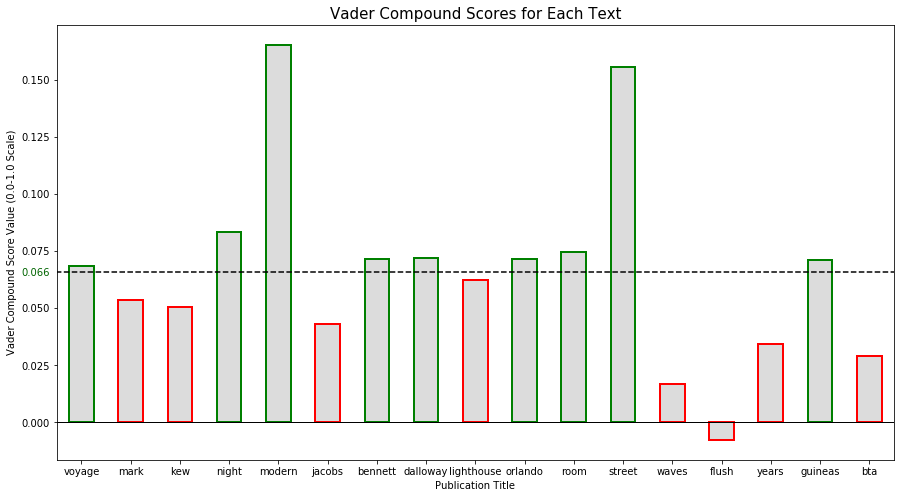

In [34]:
# ordered chronologically
# mean vader compound score for each text
df = vader_means.loc['vader_compound']
mean = df.mean()
ax = df.plot.bar(rot = 0, 
                 figsize = (15, 8), 
                 color = 'gainsboro',
                 ec = ['green', 'red','red', 'green','green','red','green','green', 'red','green','green','green','red','red','red', 'green', 'red'],
                 linewidth = 2)
ax.hlines(mean, -1, 17, linestyles='dashed')
plt.axhline(linewidth=1, color='black')
trans = transforms.blended_transform_factory(ax.get_yticklabels()[0].get_transform(), ax.transData)
ax.text(0, mean, "{:.3f}".format(mean), color="darkgreen", transform=trans ,ha="right", va="center")
plt.title("Vader Compound Scores for Each Text", fontsize = 15)
plt.xlabel("Publication Title")
plt.ylabel("Vader Compound Score Value (0.0-1.0 Scale)")
plt.show()

The bar chart above visualizes the average compound vader score for each of Woolf's texts. The average compound vader score was 0.066. On a scale of 0 to 1, across the texts analyzed in this project, the average sentimentality was 0.066 positive.

The texts that were 'sadder' than average, bordered in red, are The Mark on the Wall, Kew Gardens, Jacob's Room, To the Lighthouse, The Waves, Flush, The Years, and Between the Acts. The texts that were 'happier' than average are The Voyage Out, Night and Day, Modern Fiction, Mr. Bennett and Mrs. Brown, Mrs. Dalloway, Orlando, A Room of One's Own, Street Haunting, and Three Guineas.

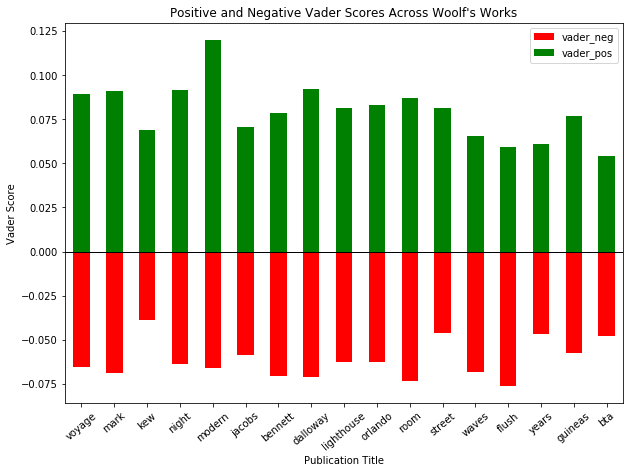

In [35]:
plotdata = vader_means.drop(['vader_neu', 'vader_compound'])
plotdata = plotdata.T
plotdata['vader_neg'] = plotdata['vader_neg']*(-1)
plotdata.plot(kind='bar', stacked=True, color = ['red', 'green'], rot = 40, figsize = (10,7))
plt.title("Positive and Negative Vader Scores Across Woolf's Works")
plt.xlabel("Publication Title")
plt.ylabel("Vader Score")
plt.axhline(linewidth=1, color='black')
plt.show()

### Chronological Emotion Across All Works
This data might be better visualized as a line plot, especially if we would like to see how the calculated vader scores increase or decrease as we move further into Woolf's career. We can find the average compound, positive, and negative vader scores for each of Woolf's texts. Then, we can see how these scores change across time and works by ordering the texts in chronological order.

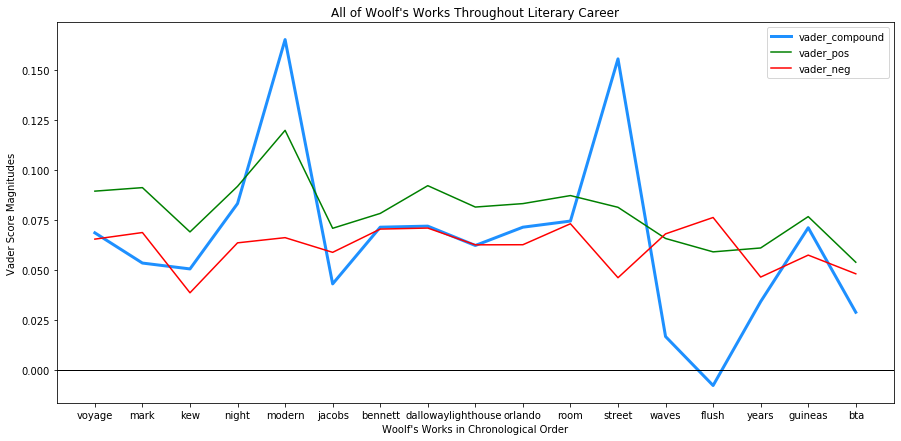

In [36]:
vad_comp = vader_means.loc['vader_compound']
vad_pos = vader_means.loc['vader_pos']
vad_neg = vader_means.loc['vader_neg']

plt.figure(figsize=(15,7))
plt.plot(vad_comp, label = 'vader_compound', color = 'dodgerblue',linewidth = 3)
plt.plot(vad_pos, label = 'vader_pos', color = 'green', linewidth = 1.5)
plt.plot(vad_neg, label = 'vader_neg', color = 'red', linewidth = 1.5)
plt.axhline(linewidth=1, color='black')
plt.xlabel("Woolf's Works in Chronological Order")
plt.ylabel('Vader Score Magnitudes')
plt.title("All of Woolf's Works Throughout Literary Career")
plt.legend()
plt.show()

As we saw before, Modern Fiction and Street Haunting have the highest vader_compound scores, meaning they are overall the most 'positive.' However, vader_compound scores are a balance of the neutral, positive, and negative vader scores. Looking at purely the vader_positive and vader_negative scores might be useful at looking at the magnitude of purely the positive and negative emotions.

The graph above plots vader_negative's intensity, so the most 'negative' text is where the vader_neg score is the highest, which would be Flush. Kew Gardens also has the lowest vader_neg score, which means it has a low negative emotion value. On the other hand, Modern Fiction and Mrs. Dalloway have the two highest positive vader scores, which means that those texts were the most positive on average, according to the Vader method. As we can see, Modern Fiction and Street Haunting had the highest calculated positivity out of the works we analyzed. However, it might be more useful to look at Woolf's works' sentiments within their individual genres.

Here, we can observe the computed fluctuations in each text's magnitude of positive and negative emotion in chronological order. It seems that Modern Fiction had the highest intensity of positive emotion, while Flush had the highest value for negative emotion. From looking at how the intensities as time passes, we can see both emotions remain relatively constant, aside from a slight decline in positive vader scores for the texts towards the latter half of Woolf's career.

### Chronological Emotion Across All Novels
Analyzing changing sentiment across all genres is useful in depicting how emotion shifts throughout Woolf's career. However, it could be interesting to focus specifically on her novels. Woolf's lyrical technique is incredibly distinctive in her irreplaceable ability to evoke and convey emotion within and between characters. Some of her most notable novels are explicitly known for their sentimentality. Graphing their sentiment, and comparing the quantitative perception of emotion for each text, may provide new insight into her most significant works.

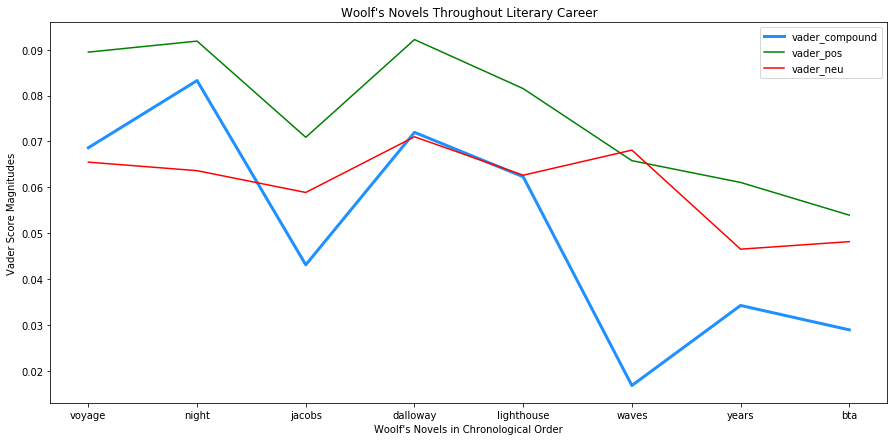

In [37]:
novel_df = vader_means[['voyage', 'night', 'jacobs', 'dalloway', 'lighthouse', 'waves', 'years', 'bta']]
novel_vad_comp = novel_df.loc['vader_compound']
novel_vad_pos = novel_df.loc['vader_pos']
novel_vad_neu = novel_df.loc['vader_neg']

plt.figure(figsize=(15, 7))
plt.plot(novel_vad_comp, label = 'vader_compound', color = 'dodgerblue',linewidth = 3)
plt.plot(novel_vad_pos, label = 'vader_pos', color = 'green',linewidth = 1.5)
plt.plot(novel_vad_neu, label = 'vader_neu', color = 'red',linewidth = 1.5)
plt.xlabel("Woolf's Novels in Chronological Order")
plt.ylabel('Vader Score Magnitudes')
plt.title("Woolf's Novels Throughout Literary Career")
plt.legend()
plt.show()

The graph above shows a decline in overall positivity as Woolf's literary career progresses, specifically with the publication of novels. The Voyage Out, published in 1915, was Woolf's first novel. Night and Day, 1919, was considered by Woolf to be her "traditional" novel, in the manner of the nineteenth-century novelists she admired. Jacob's Room, 1922, was her first truly experimental novel based on her elder brother, Thoby Stephen, who died of a fever in 1906. The somber source of inspiration for Jacob's Room might explain the dip in positive sentiment.

Moving forward, we see a surge in positive sentiment in Mrs. Dalloway, 1925. We see that, overall, Mrs. Dalloway has a lower vader_compound score than Night and Day. However, it also has more extreme emotion, as shown by its higher intensity vader_pos and vader_neg scores.  The amplitude of emotion provides a new way of interpreting the text, in combination with our knowledge of its main characters' polarity -- particularly, the schizophrenic Septimus Smith.

After Mrs. Dalloway, Woolf's texts drop in positive sentiment, according to the Vader method. If this is true, then drawing on the context of these texts might provide meaning. The publication of Mrs. Dalloway and To the Lighthouse are the peaks of Woolf's career; they help her garner international acclaim and recognition. These two works indeed are her most famous works.

To the Lighthouse is then followed by The Waves, a novel generally considered to be Woolf's masterpiece, while also her most experimental and challenging work. Although this novel is perhaps her most distinguished, it remains to this day her most enigmatic. Consisting of nine chapters, each describes a stage in six characters' lives from childhood to old age. Considered her most solemn piece,  the visualization above certainly supports the preconceived perception of The Wave's melancholy. Indeed, The Waves has the lowest vader_compound score, as well as the highest vader_neg score.

Published in 1937, The Years traces the life of a Victorian family from 1880 to "Present Day." This novel started as a sequel to A Room of One's Own, with the initial intention to alternate nonfiction essays the family's story. However, Woolf ultimately extracted the nonfiction sections.

Woolf's last novel, published posthumously in 1941, takes place in a short period in June of 1939, focused on a play hosted in a local town. Woolf had yet to correct the typescript of the novel at the time of her death, and thus many critics consider Between the Acts to be an unfinished novel. In this novel, the reader can sense the lingering ramifications of World War 1 and the anxious anticipation of World War 2. With Woolf's worsening mental health as a background for the creation of Between The Acts, one can understand why we see a decline in vader_compound scores for this novel. Woolf's last work, Between the Acts, illustrates Woolf's mounting concern at the threat of war, with her degrading happiness.

## How Emotions Change Within Each Text's Narrative
### Novels:
Looking more closely at individual novels, we can see how the vader_scores fluctuate within each narrative. It might be interesting to see, especially with novels such as Mrs. Dalloway, To the Lighthouse, and Between the Acts, where time plays an integral role in the text's progression and how emotion fluctuates within. Below, oscillations in vader_compound, vader_pos, and vader_neg help visualize any trends in the ebb and flow of emotion across each text.

As each novel is of different lengths, we had to use the same reference points for time. To do this, we divided each novel into fifteen segments and found the average vader scores for each sentence within the fifteen segments. Thus, we can plot the fifteen segments' emotion values and compare them across different time points in each text. 

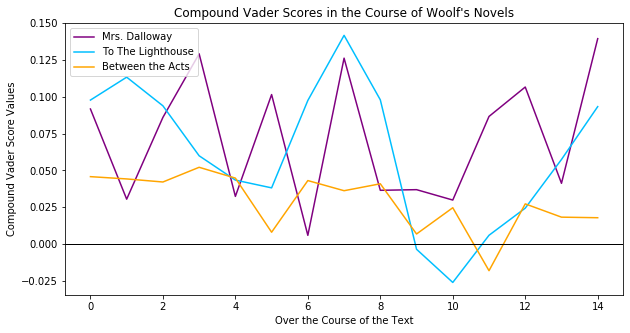

In [38]:
# Vader Compound Chronologically -- Novels
# Mrs. Dalloway, 1925
md = mrs_dalloway_vader['vader_compound']
md_ave = md.groupby(np.arange(len(md))//(len(md)/15)).mean()

# To the Lighthouse, 1927
ttl = to_the_lighthouse_vader['vader_compound']
ttl_ave = ttl.groupby(np.arange(len(ttl))//(len(ttl)/15)).mean()

# Between the Acts, 1941
bta = between_the_acts_vader['vader_compound']
bta_ave = bta.groupby(np.arange(len(bta))//(len(bta)/15)).mean()

plt.figure(figsize=(10, 5))
plt.plot(md_ave, label = "Mrs. Dalloway", color = 'purple')
plt.plot(ttl_ave, label = "To The Lighthouse", color = 'deepskyblue')
plt.plot(bta_ave, label = "Between the Acts", color = 'orange')

plt.xlabel('Over the Course of the Text')
plt.ylabel('Compound Vader Score Values')
plt.axhline(linewidth=1, color='black')
plt.title("Compound Vader Scores in the Course of Woolf's Novels")
plt.legend()
plt.show()

**Novel Analysis:**<br>
This visualization presents a shared pattern across the three texts, with the emotional fluctuations of To The Lighthouse and Between the Acts being the most similar. A few common themes and characteristics across these three texts are intriguing to revisit in the context of this visualization.

First, Mrs. Dalloway takes place entirely in one day, in the life of Clarissa Dalloway and her double, Septimus Smith, the shell-shocked WW1 veteran. The entire novel spans only one day in July, and is centered around the social event that night, the party Mrs. Dalloway is hosting. At this party, she hears of the suicide of Septimus Smith, which could be shown by the sudden drop in the vader score towards the end of the story's narrative. We also see that Mrs. Dalloway has a significant amount of extreme highs and lows in vader_score. In Mrs. Dalloway, a considerable amount of the discourse is dictated by the polarizing, sporadic, and extreme emotions and anxieties of the schizophrenic Septimus Smith. Perhaps, these spikes are a signal of precisely that; they show the extraordinary intensity of which the characters feel; the depression, mania, trauma, and fervor throughout their narratives, particularly Septimus.

Like Mrs. Dalloway, To The Lighthouse experiences extreme highs and extreme lows, as shown by the vader_compound score reaching almost as high as 0.15 and subsequently dropping to almost -0.025. To The Lighthouse is divided into three segments, with the first being the longest. While it is hard to tell where these three segments might lay on the plot above, we can see three prominent 'highs' at 1, 7, and 15, and two 'lows' at 5 and 10. In Part 1: The Window, the section begins with the Ramsay's discussion of visiting the Lighthouse, and moves on to the characters Lily Briscoe, Charles Tansley, and Augustus Carmichael, among a few others. This section closes with a large dinner party, ending with Mr. and Mrs. Ramsay interacting, alone, at the end of the night. In the next section, Part 2: Time Passes, ten years pass, during which the First World War starts and ends. We find out that Mrs. Ramsay, and two of her children, also die, one killed in the war.

In the final section, Part 3: The Lighthouse, the Ramsays, and some of their past guests, return to their summer home after ten years and finally make the trip to the Lighthouse. This section might be seen on the graph from point 10-15, with the gradual increasing positivity of the vader scores. We see the mood improve from Section 2, which focused predominantly on the abandonment of the summer home, the implications of WW1, and the Ramsay family members' loneliness. However, in section 3, we finally see the characters experience harmony between each other: Mr. Ramsay praises James on their sail over to the Lighthouse, Cam slowly trades her resentment towards her father for compassion and respect, and Lily finally finishes her painting to a point in which she is satisfied; the Lighthouse is reached, the family's tension has fizzled, and Lily discovered the true meaning behind her work.

Lastly, in this visualization, we see that Between the Acts is computed to be the saddest novel of the three, with vader_compound scores consistently lower than the other two. The novel's sentiment fluctuates, albeit to a much smaller degree than the other two texts, and stays between the 0.00-0.05 range. Between the Acts itself flits between not just various characters, but various time periods, as Miss La Trobe's play portrays centuries of famous literature and theatre. After multiple pathways and trajectories, the novel ends in a moment of suspension, dispersion, and anticipation.

As reflected in the visualization above, we see multiple smaller fluctuations, rather than sweeping shifts between sentiment like in the other two novels. Towards the end of the novel, we see a plateau -- the curtain's opening, the question left unanswered, the anticlimactic dispersion of the audience escaping the literary world and returning to their material one. Woolf, shortly after writing the typescript of Between the Acts, decided to end her own life, due to the onset of another terrible period of mental illness, paired with the anticipation of an oncoming invasion by Hitler. The novel itself dissipates into an open ending; questions are left unanswered, and the book unfinished.

## Short Stories:
Another primary genre in which Woolf contributed beautiful works of literature was short stories; her two most notable ones being Mark on the Wall, her first publication, and Kew Gardens. We will look at these two short stories, alongside a short story that came a dozen years later: Street Haunting: A London Adventure, 1930.

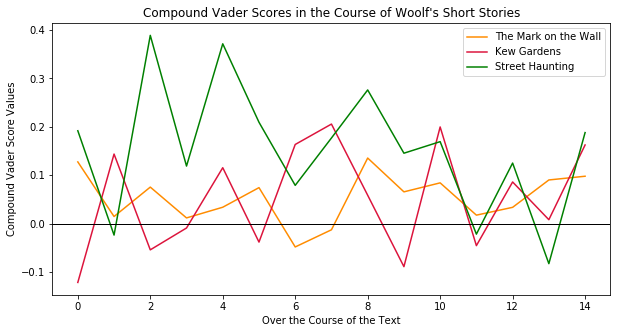

In [39]:
# Vader Compound Chronologically -- Short Stories

# Mark On the Wall, 1917
mw = mark_on_the_wall_vader['vader_compound']
mw_ave = mw.groupby(np.arange(len(mw))//(len(mw)/15)).mean()
# Kew Gardens, 1919 
kw = kew_gardens_vader['vader_compound']
kw_ave = kw.groupby(np.arange(len(kw))//(len(kw)/15)).mean()
# Street Haunting, 1930 
sh = street_haunting_vader['vader_compound']
sh_ave = sh.groupby(np.arange(len(sh))//(len(sh)/15)).mean()

plt.figure(figsize=(10, 5))
plt.plot(mw_ave, label = "The Mark on the Wall", color = 'darkorange')
plt.plot(kw_ave, label = "Kew Gardens", color = 'crimson')
plt.plot(sh_ave, label = "Street Haunting", color = 'green')

plt.xlabel('Over the Course of the Text')
plt.ylabel('Compound Vader Score Values')
plt.title("Compound Vader Scores in the Course of Woolf's Short Stories")
plt.axhline(linewidth=1, color='black')
plt.legend()
plt.show()

**Short Stories Analysis:**<br>
Initially, one can notice the separation between The Mark on the Wall and Kew Gardens, with Street Haunting. Perhaps this is a sign of the times; as we saw with her novels, Woolf's work experienced a decline in overall positive sentiment as time went on. The Mark on the Wall and Kew Gardens are also much more similar in lyrical style. Published within two years of each other, The Mark on the Wall and Kew Gardens are often juxtaposed together.

The Mark on the Wall was published by subscription in a venture called "Two Stories," in July 1917 as the Hogarth Press's first publication. The Mark on the Wall is invaluable in the ways Woolf can fill the piece with incredibly evocative, engaging, and articulate emotions and thoughts, all stimulated by an obscure mark on the wall, a snail. This story is one of the first in literary history to attach such significance to how each human individually perceives, interprets, and reacts to the world around them.

In "Kew Gardens" (1919), Woolf takes the snail from "The Mark on the Wall" and uses it as her principal narrative angle for "Kew Gardens." The conversations, thoughts, and emotions of passersby are perceived and conveyed from the snail on the flower bed. This narrative form was an entirely new way of storytelling, as time and space are fragmented, speech and thought are fractured. From the insipient literary experimentation in "The Mark on the Wall" and "Kew Gardens," Woolf created full-length masterpieces of literary innovation, such as Jacob's Room, and later perfect this technique in Mrs. Dalloway and To the Lighthouse.

Street Haunting, published in a collection of short stories called "Monday and Tuesday" in 1927, describes an expedition on London's winter streets at night. Unlike "The Mark on the Wall" and "Kew Gardens," the narrative perspective is transitory; it explores alleyways, dives into bookstores, interacts with passersby, imagines itself in others' homes. However, the formerly discussed short stories draft storylines from the perspective of a narrator who stays stationary. Perhaps this influences each short story; the static nature of the narrator in the first two texts allows the insertion of multiple more perspectives, hence the oscillating emotion per the various transitions between characters. Meanwhile, in "Street Haunting," the narrator must physically move in order to 'emotionally' move from perspective to perspective, a tedious process, which as a result, happens less frequently, but more dramatically.

## Biographies:
Woolf wrote three biographies: Orlando, Flush, and Roger Fry. Due to difficulties accessing an online eBook for Roger Fry, we are able to look at only Orlando and Flush. 

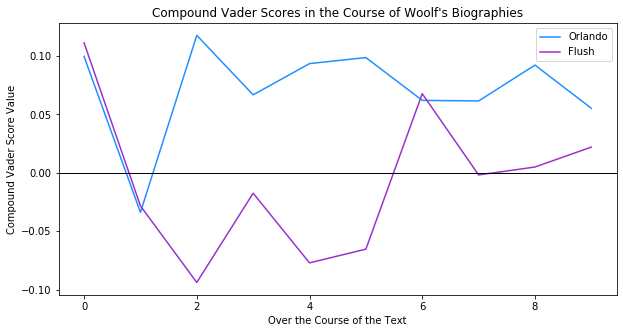

In [40]:
# Vader Compound Chronologically -- Biographies

# Orlando, 1928
orl = orlando_vader['vader_compound']
orl_ave = orl.groupby(np.arange(len(orl))//(len(orl)/10)).mean()
# Flush, 1933
flu = flush_vader['vader_compound']
flu_ave = flu.groupby(np.arange(len(flu))//(len(flu)/10)).mean()

plt.figure(figsize=(10, 5))
plt.plot(orl_ave, label = "Orlando", color = 'dodgerblue')
plt.plot(flu_ave, label = "Flush", color = 'darkorchid')

plt.xlabel('Over the Course of the Text')
plt.ylabel('Compound Vader Score Value')
plt.title("Compound Vader Scores in the Course of Woolf's Biographies")
plt.axhline(linewidth=1, color='black')
plt.legend()
plt.show()

**Biographies Analysis:**<br>
Flush and Orlando are depicted to be quite the opposite of each other throughout each respective text, with respect to the vader compound scores. According to the graph above, when Orlando is around its peak positivity, at that same point in the text (relative to each text's length, in this case, two tenths into the book), Flush is at its peak negativity.

Orlando: A Biography (1928) fuses biography with fantasy, evading gender and time restrictions. It depicts the poet Orlando, who lives from the Elizabethan times to the day of the biography's publication while turning from a man to a woman halfway into the novel. Besides an entertaining escape from her heavier pieces, Orlando also serves as a love-letter to her close friend and lover, Vita Sackville-West. This "biography," filled with audacity and irreverence, was an immediate sensation. Meanwhile, Flush: A Biography (1933) was a comic novel written from the point of view of Elizabeth Barret Browning's cocker spaniel, Flush. Despite being relatively light-hearted, Flush has vader_compound scores that fall into the negative for most of the narrative. After completing her emotionally draining novel, Woolf wrote this biography, The Waves, so perhaps lingering melancholy from the creation of The Waves manifest itself in Flush.

Unlike with other visualizations, the differences across texts in this genre are harder to justify, given our literary understanding. It might be useful to look at exactly what sentences are the saddest and happiest in these respective biographies. Flush is not typically categorized as one of Woolf's most depressing or melancholy texts, so we can try looking at the most 'emotional' sentence in the text to help us find the answer.

In [41]:
def sentence_min(text_vader):
    '''Use the vader scores to locate the sentence associated with the lowest vader_compound score.
    Returns the "saddest" sentence, or the sentence with the lowest vader_compound. '''
    min_ = text_vader[text_vader['vader_compound']==text_vader['vader_compound'].min()]
    print("The most negative, or 'saddest', sentence: \n", min_.iloc[0]['sentence'])
    
def sentence_max(text_vader):    
    '''Use the vader scores to locate the sentence associated with the highest vader_compound score.
    Returns the "happiest" sentence, or the sentence with the highest vader_compound. '''
    max_ = text_vader[text_vader['vader_compound']==text_vader['vader_compound'].max()]
    print("The most positive, or 'happiest' sentence: \n", max_.iloc[0]['sentence'])

We can create a function that allows us to find the lowest vader_compound score for each text and then locate the sentence associated with that score. We can also do this for the highest vader_compound score to see the 'saddest' and the 'happiest' sentences of each text.

In [42]:
# Finding the saddest sentence in Flush
sentence_min(flush_vader)

The most negative, or 'saddest', sentence: 
 Thirst was his worst suffering; but one sip of the thick greenish water that stood in a pail near him disgusted him; he would rather die than drink another.


While the uncovering of these sentences might not be the most ground-breaking, it is interesting to see how the Vader method can identify each text's negative and positive sentences and the words within each sentence that lead to this classification. In Flush, the saddest sentence is grounded in the dog's physical state: his thirst and his disgust for the water in front of him. This could explain why Flush has such a low vader_compound score; rather than being weighted down by negative words discussing heavier subjects surrounding death, depression, or trauma, the text is littered with negative words about more trivial matters. Thus, the Vader method picks up many negative words, making Flush Woolf's most 'negative' text according to vader_compoudn scores. However, as readers, we do not perceive Flush as a necessarily sad text since we discern the negativity about trivial matters from significant ones.

## Essays
Woolf was also extremely well-known for her writings promoting liberal politics, particularly the feminist and anti-fascist movements. Her two most notable political pieces are A Room of One's Own and Three Guineas. This study also analyzes Woolf's two essays that pose compelling arguments and opinions in the context of literature, Mr. Bennett and Mrs. Brown, and Modern Fiction.

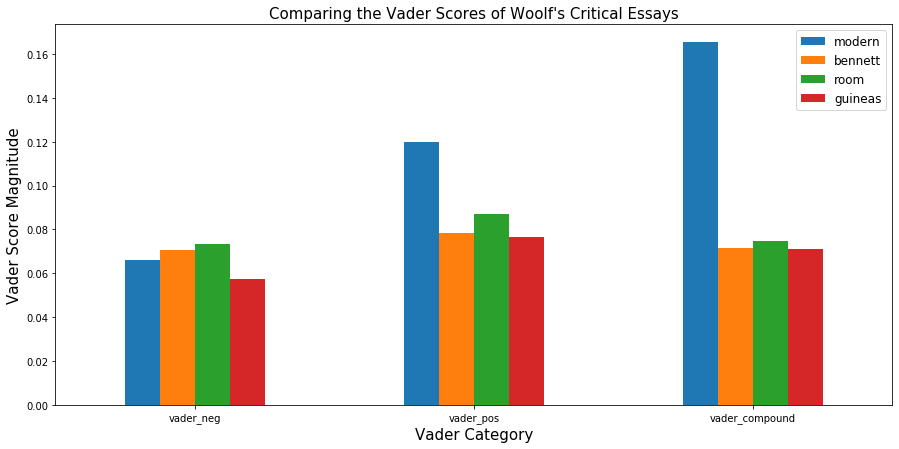

In [43]:
novel_df = vader_means[['modern', 'bennett', 'room', 'guineas']].drop(['vader_neu'])
ax = novel_df.plot.bar(rot=0, figsize = (15,7))
ax.legend(fontsize=12)
plt.title("Comparing the Vader Scores of Woolf's Critical Essays", fontsize = 15)
plt.xlabel('Vader Category', fontsize = 15)
plt.ylabel('Vader Score Magnitude', fontsize = 15)
plt.show()

**Essay Analysis:**<br>
"Modern Fiction" is perhaps the best known of all Virginia Woolf's essays. Woolf's argument in this essay is built on the materialistic preoccupation so novelists who see only the body and nothing of the mind. She argues that the future novels must leave the external world, focus more closely on the interior of human experiences, look inside the mind on an ordinary day, and turn these objects into the novel's subject. This principle is upheld throughout her texts, particularly Jacob's Room, Mrs. Dalloway, and To the Lighthouse. In the same vein, Woolf's essay Mr. Bennett and Mrs. Brown are also critical essays that discuss literary creation. Mr. Bennett and Mrs. Brown serves as a literary manifesto that repudiates the earlier generations' novels, as they invented trivia to fill their pages, thus depriving readers of insight into human character. Prior novelists would have refused to look deeply at life and the intricacy of human character.

Meanwhile, Woolf's essays A Room of One's Own and Three Guineas take a stance on a broader, more controversial stage. A Room of One's Own, published in 1929, stands as the classic essay on feminism, characterized by its shrewd reasoning. In this essay, Woolf argues for equal rights for both sexes, proves how women are deprived of powers and privileges, and imagines instances that illustrate how women have been kept mute, maternal, poor, and oppressed. Three Guineas, 1938, serve as a sequel to A Room of One's Own while also branching off to dive into the realm of war and fascism. In the growing threat of another world war, Woolf critiques patriarchy and fascism, highlighting women's oppression in society and the male norms of violence, competition, and domination.

One can understand why A Room of One's Own and Three Guineas might have very similar vader scores. However, this visualization showcases a surprising spike in vader_pos and vader_compound for Modern Fiction, a spike that fails to be reflected in the similar essay Mr. Bennett and Mrs. Brown. Again, it might be useful to see where this dissimilarity is coming from through these texts'  extraordinarily positive and negative sentences. For example, how do the 'saddest' sentences in each of Woolf's critical essays compare -- do they all speak of the same topics, critiquing the same societal downfalls and disappointments? 

In [44]:
# Modern Fiction
sentence_max(modern_fiction_vader)

The most positive, or 'happiest' sentence: 
 But let this sympathy be not with the mind--for it is easy with the mind--but with the heart, with love towards them".


The sentence with the highest vader_comp score in Modern Fiction is "But let this sympathy be not with the mind--for it is easy with the mind--but with the heart, with love towards them." This does not necessarily give us a great deal of insight into why the text might be considered the most positive. However, while looking at the highs and lows of these critiques, it would be interesting to look at the most negative sentences in Woolf's two political polemics, A Room of One's Own and Three Guineas.

In [45]:
# A Room of One's Own
sentence_min(room_of_ones_own_vader)

The most negative, or 'saddest', sentence: 
 His expression suggested that he was labouring under some emotion that made him jab his pen on the paper as if he were killing some noxious insect as he wrote, but even when he had killed it that did not satisfy him; he must go on killing it; and even so, some cause for anger and irritation remained.


In [46]:
# Three Guineas
sentence_min(three_guineas_vader)

The most negative, or 'saddest', sentence: 
 ) This raises the difficult question whether those who did not aid in the prosecution of the war, but did what they could to hinder the prosecution of the war, ought to use the vote to which they are entitled chiefly because others 'aided in the prosecution of the war'?


There seems to a common thread between these two sentences in the deliberate mention of "killing" and "war" in each respective sentence. In A Room of One's Own, the most negative sentence discusses the male nature of domination or control, how society normalizes violence by men, and engrains in them an insatiable desire to oppress. Then, in Three Guineas, this sentence uses the phrase "prosecution in the war" three times, discussing the role of an individual in the war's prosecution. When thinking back to the text, I am sure many other sentences might be more violent. However, it might be the repeated use of that phrase that consistently amplifies the negativity of war; although, in context, one might view the war's prosecution as a positive.

# Concluding Thoughts

Emotion, particularly in Woolfean literature, is an incredibly elusive and evasive characteristic to quantify. However, through text-mining, semantic analysis, and data visualizations, we can try to find ways to accurately capture objective illustrations of this very subjective nature that underlays each of Woolf's texts. These dataframes, summary statistics, and visualizations provide new lenses through which we could re-explore and re-imagine Woolf's texts. While our quantitative analyses might not have always given us the answers to our qualitative ambiguities, they provoked intriguing new questions to ask, uncovered unseen similarities across texts, and unmasked an uncharted side to understanding the worlds Woolf created.

In [47]:
%%javascript
let words = 0;
Jupyter.notebook.get_cells().forEach(cell => {if (cell.cell_type == "markdown") { words += cell.element[0].innerText.split(" ").length }})
element.text("markdown words: " + words)

<IPython.core.display.Javascript object>

## Acknowledgements
Thank you to Professor Elizabeth Evans for providing me with the space and time to take on this challenging expedition! This project would not have been possible without your encouragement, guidance, and all I have learned about Woolf this past semester.

I would also like to acknowledge Project Gutenberg for publishing free online versions of Virginia Woolf's texts. Without their efforts to digitize, archive, and distribute our society's greatest literary accomplishments, this research would not have been possible.

Finally, I would like to recognize the informative references I have used throughout this project, as listed below. They were critical in helping me fully understand the Vader method, as well as the few Woolfean texts I was unfamiliar with before this project.

### References
Beri, Aditya. “SENTIMENTAL ANALYSIS USING VADER.” Medium, Towards Data Science, 27 May 2020, towardsdatascience.com/sentimental-analysis-using-vader-a3415fef7664. 

Caren, Neal. “Word Lists and Sentiment Analysis.” Neal Caren, 1 May 2019, nealcaren.org/lessons/wordlists/. 

Cersonsky, Emily. “Virginia Woolf.” Virginia Woolf: The Core Curriculum, Columbia Univeristy, 2020, college.columbia.edu/core/content/virginia-woolf. 

McGinn, Emily, et al. “Scholarly Editing.” Scholarly Editing: The Annual of the Association for Documentary Editing, 2014, scholarlyediting.org/2014/editions/intro.markonthewall.html. 

Virginia Woolf, The Virginia Woolf Reader. Ed. Mitchell Leaska. Harcourt, 1984.